# Multi-Armed Bandit for Data Selection

We follow in the footsteps of Gutiérrez et al (2017). Let us first formulate our objective mathematically.

#### Modelling Objective

We want to model $f: (x, \mathbf{p}) \mapsto y$, where $f$ belongs to the class of linear regression estimators parameterized by vector $\mathbf{p}$. $x_i$  and $y_i$ are the RH98 and AGBD of footprint $i$, respectively. 

Parameters $\mathbf{p}$ are estimated using a training set $S^T = \{ s_1, \ldots, s_{N_{\text{train}}} \}$ consisting of samples $s = (x,y)$. However, $S^T$ is merely a subsample from the available training data $S = \{ h_1, \ldots, h_{N_{\text{total}}} \} $ which consists of _hidden_ samples of the form $h = \{ \tilde{x}, \tilde{y}, \mathbf{m} \}$. They are hidden because RH98 $\tilde{x}$ and AGBD $\tilde{y}$ are only revealed after the sample is added to the training set. By contrast, metadata $\mathbf{m}$ about the sample is known à priori. To begin with, $S$ consists of all data in Ghana with PFT class = 2. 

#### Sample Efficiency Objective

Unlike Gutiérrez et al, we do not incur a large cost from observing $\tilde{x}$ or $\tilde{y}$. However, we are interested in selecting only the most relevant samples according to $\mathbf{m}$ all the same. We will later generalise our method to larger, more complicated datasets and more sophisticated model classes, hence sample efficiency will be important to minimise the computational burden of training the model.

We select samples by partitioning $S$ into a pre-defined number of bins $\eta_j$ for select $m_j$ $(1 \leq j \leq d)$ in $\mathbf{m}$. For instance, if $m_j$ is a categorical variable with four categories, we create the j'th partition $S = \bigcup_{k=1}^{4} C_k^j$, where $C_1^j$ contains all samples where $m_j$ is in class 1, $C_2^j$ contains all samples where $m_j$ is in class 2, etc. If $m_j$ is continuous, we quantize the variable into bins and partition accordingly. All the clusters generated using different meta information are then merged into a set of clusters $\mathcal{C} = \{C_l^j\}$. Our hypothesis is that some clusters $C_i \in \mathcal{C}$ contain more relevant information for the modelling task than others, but we do not know which. This motivates us to train a multi-armed bandit who will simultaneously _explore_ the clusters to find out which contain the most relevant information and eventually _exploit_ these clusters to maximise the share of data therefrom.

The multi-armed bandit algorithm is described in detail in their paper, but to summarise:

* At every time $t$:
    * Sample the probability of reward $\hat{\pi}_i$ from $Beta(\alpha_i, \beta_i)$ for every cluster
    * Pick a datapoint $s$ from the cluster with highest probability of reward
    * Add $s$ to $S^T$ and re-train the model
    * Predict $\hat{y}$ for a holdout validation set
    * If score increases (decreases), $r_t = 1 \ (-1)$
    * Update $\alpha_i, \beta_i$ based on $r_t$ 

#### Summary of Objective

Our dual objectives are then:

1) To optimize the performance of $f$ at predicting $y$, as measured by the MAPE on a holdout test set.
2) To include as few samples as necessary in $S^T$.

We will train a multi-armed bandit data selector to achieve both in parallel.

### Load Packages and Data

In [ ]:
import pandas as pd
import geopandas as gpd
import pyogrio
import os
import pandas.api.types as ptypes
import numpy as np
import warnings
import pickle as pkl
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error, r2_score, explained_variance_score, mean_squared_error # , root_mean_squared_error
from matplotlib import pyplot as plt
from scipy.stats import beta

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir(r"C:\Users\nial\OneDrive\ETH Zürich\Master Thesis")

Manually set `dtypes`

In [ ]:
dtypes = {
     'pft_class': 'category'
    ,'region_cla': 'category'
    ,'leaf_off_f': 'category'
    ,'urban_prop': 'int64'
    ,'agbd': 'float64'
    ,'agbd_se': 'float64'
    ,'beam': 'category'
    ,'elev_lowes': 'float64'
    ,'lat_lowest': 'float64'
    ,'lon_lowest': 'float64'
    ,'selected_a': 'category'
    ,'shot_numbe': 'int64'
    ,'sensitivit': 'float64'
    ,'solar_elev': 'float64'
    ,'rh98': 'float64'
    ,'pattern': 'object'
    ,'doy_sin': 'float64'
    ,'doy_cos': 'float64'
    ,'date': 'int64'
    ,'lat_cos': 'float64'
    ,'lat_sin': 'float64'
    ,'lon_cos': 'float64'
    ,'lon_sin': 'float64'
    ,'pft_class_group': 'category'
    ,'geometry': 'object'
}

df_ghana_subsample = pd.read_csv('df_ghana_subsample.csv', dtype=dtypes)

Save `df_ghana`

In [ ]:
df_ghana = gpd.read_file("GEDI_Ghana.geojson"
                         , driver = 'GeoJSON'
                         , engine='pyogrio')

df_ghana = df_ghana[df_ghana['pft_class'] == 2]

cols_to_keep = ['pft_class', 'leaf_off_f','urban_prop','agbd','agbd_se', 'beam', 'selected_a', 'sensitivit'\
                     , 'solar_elev', 'rh98', 'date', 'lat_cos','lat_sin','lon_cos','lon_sin', 'geometry']

df_ghana = df_ghana[cols_to_keep]

df_ghana.to_csv("df_ghana.csv", index=False)

df_ghana.head(5)

Load `df_ghana`

In [ ]:
dtypes = {
     'pft_class': 'category'
    ,'leaf_off_f': 'category'
    ,'urban_prop': 'int64'
    ,'agbd': 'float64'
    ,'agbd_se': 'float64'
    ,'beam': 'category'
    ,'selected_a': 'category'
    ,'sensitivit': 'float64'
    ,'solar_elev': 'float64'
    ,'rh98': 'float64'
    ,'date': 'int64'
    ,'lat_cos': 'float64'
    ,'lat_sin': 'float64'
    ,'lon_cos': 'float64'
    ,'lon_sin': 'float64'
    ,'geometry': 'object'
}

df_ghana = pd.read_csv("df_ghana.csv", dtype=dtypes)

### Define `bandit` class

In [ ]:
class bandit:
    """
    Bandit to select data for optimizing the model f.

    INPUTS:
    dataset: includes columns x and y
    x: name(s) of independent variable(s)
    y: column name of dependent variable
    features: along which to cluster df, including n_bins if numeric
    T: number of train points to sample before terminating (must be < frac_train * len(dataset))
    batch_size: number of points to sample before computing reward
    frac_train: fraction of dataset for training
    frac_test: fraction of dataset for testing
    frac_val: fraction of dataset for validation
    test_freq: frequency at which to evaluate the model fit on test set
    """

    def __init__(self, dataset: pd.DataFrame, x: str, y: str, features: dict, T: int=1000, batch_size: float=1\
                 , frac_train: float=0.5, frac_test: float=0.48, frac_val: float=0.02, test_freq: int=10):

        # store inputs
        self.dataset            = dataset
        self.x                  = x
        self.y                  = y
        self.features           = features
        self.T                  = T
        self.batch_size         = batch_size
        self.frac_train         = frac_train
        self.frac_test          = frac_test
        self.frac_val           = frac_val
        self.test_freq          = test_freq

        # instantiate lists
        self.hidden_indices     = []
        self.test_indices       = []
        self.val_indices        = []
        self.train_indices      = []
        self.clusters           = []
        self.prev_score         = -np.infty
        self.current_score      = -np.infty
        self.val_scores         = []
        self.test_scores        = []
        self.rewards            = []
        self.sampled_C          = []
        
        # clusters and TTV split
        self.clean_clusters()
        self.generate_clusters(features)
        self.ttv_split()

        # model and score function
        self.model              = Lasso(tol=1e-2)
        self.predictor_count    = 1 if type(x) is str else len(x)
        self.score              = mean_squared_error # mean_absolute_percentage_error # r2_score
        self.lower_is_better    = True

    def clean_clusters(self):
        """
        Upon initialization, delete all previous cluster assignments.
        """
        cluster_cols = [c for c in self.dataset.columns if 'cluster_ID_' in c]
        self.dataset.drop(columns=cluster_cols, inplace=True)
        self.clusters.clear()

    def generate_cluster(self, feature: str, n_bins: int=10):
        """
        Partitions the data into clusters along the specified metadata variable.
        If the feature is categorical, then the categories determine the clusters.
        If the feature is numeric, then the feature is quantized into n_bins clusters.

        INPUTS:
        feature: name of feature in dataset along which to define clusters.
        n_bins: number of bins, if feature is numeric.

        OUTPUTS:
        Adds column to self.dataset indicating the cluster ID of an observation along the given metadata feature.
        """
        # get column
        try: cluster_column = self.dataset[f'{feature}']
        except KeyError: raise KeyError(f"Column {feature} does not exist in dataset")

        # numeric
        if ptypes.is_numeric_dtype(cluster_column):

            # -1 for bins
            cluster_ids, bins   = pd.qcut(cluster_column, q=n_bins-1, labels=False, duplicates='drop', retbins=True)
            cluster_ids         = cluster_ids.apply(lambda c_id: bins[c_id])

        # categorical
        elif ptypes.is_categorical_dtype(cluster_column):
            
            cluster_ids         = cluster_column

        # unique
        unique_clusters = cluster_ids.unique()

        # save IDs
        feature_name               = f"cluster_ID_{feature}"
        self.dataset[feature_name] = cluster_ids

        # save clusters
        for cluster_name in unique_clusters:
            self.clusters.append((feature_name, cluster_name))

        # instantiate prior distributions
        self.num_clusters       = len(self.clusters)
        self.alphas             = np.ones(self.num_clusters)
        self.betas              = np.ones(self.num_clusters)
            
    def generate_clusters(self, features: dict):
        """
        Partitions the data into clusters along the specified metadata variables.
        
        INPUTS:
        features: dictionary of form {feature: n_bins}. The n_bins argument is ignored when feature is categorical.
        """
        for feature, n_bins in features.items():
            self.generate_cluster(feature, n_bins)
        
    def ttv_split(self):
        """
        Split dataset into train, test and validation components.
        """
        data_size = len(self.dataset.index)
        assert np.isclose(self.frac_train + self.frac_test + self.frac_val, 1.0), "Train, test, validation fractions must sum to 1"

        pos_train           = int(data_size * self.frac_train)
        pos_test            = int(data_size * self.frac_test)

        split_points        = [pos_train, pos_train + pos_test]

        hidden_indices, test_indices, val_indices \
                            = np.split(self.dataset.sample(frac=1), split_points)

        self.hidden_indices = hidden_indices.index.tolist()
        self.test_indices   = test_indices.index.tolist()
        self.val_indices    = val_indices.index.tolist()

    def sample_reward_probabilities(self):
        """
        Sample reward probabilities from multivariate Beta distribution.
        """
        pi = np.array([np.random.beta(a, b) for a, b in zip(self.alphas, self.betas)]).T
        return pi

    def sample_datapoint(self, pi: np.ndarray):
        """
        Sample a datapoint and add to the training dataset. Return cluster sampled.

        INPUTS:
        pi: reward probabilities
        """
        # find first non-empty cluster from which to sample
        pi_descending   = np.argsort(pi)[::-1]
        counter         = 0

        # runs at least once and until a non-empty cluster is found
        while counter == 0 or cluster.empty:
            j               = pi_descending[counter]
            feature, value  = self.clusters[j]
            
            # implicitly converts index for .isin() to work
            cluster         = self.dataset[(self.dataset[feature] == value)]
            cluster         = cluster[cluster.index.isin(self.hidden_indices)]

            counter += 1
        
        # pick datapoint
        cluster_size    = len(cluster.index)
        s_index         = np.random.randint(0, cluster_size)
        s               = cluster.index[s_index]

        self.train_indices.append(s)
        try: self.hidden_indices.remove(s)
        except ValueError: raise ValueError(f"s = {s}")
        self.sampled_C.append(j)
        return j
    
    def score_prediction(self, y: np.ndarray, y_hat: np.ndarray):
        """
        Compute score for predictions.

        INPUTS:
        y: true values
        y_hat: predicted values
        """
        # return self.score(y, y_hat)

        # no 0 preds 
        y_hat = np.where(y_hat < 0, 0.01, y_hat)
        return np.median(np.abs(np.log(y_hat/y)))


    def compute_reward(self):
        """
        Compute reward with current train indices.
        """
        X_train = self.dataset[self.dataset.index.isin(self.train_indices)][self.x].to_numpy()
        y_train = self.dataset[self.dataset.index.isin(self.train_indices)][self.y].to_numpy()
        X_val   = self.dataset[self.dataset.index.isin(self.val_indices)][self.x].to_numpy()
        y_val   = self.dataset[self.dataset.index.isin(self.val_indices)][self.y].to_numpy()

        # reshape if single feature
        if self.predictor_count == 1: 
            X_train = X_train.reshape(-1, 1)
            X_val   = X_val.reshape(-1,1)

        self.X_train= X_train 
        self.model.fit(X_train, y_train)

        y_val_hat           = self.model.predict(X_val)
        self.prev_score     = self.current_score
        self.current_score  = self.score_prediction(y_val, y_val_hat)

        # allocate reward
        if self.lower_is_better: reward = 1 if self.current_score < self.prev_score else 0
        elif not self.lower_is_better: reward = 1 if self.current_score > self.prev_score else 0

        self.rewards.append(reward)
        self.val_scores.append(self.current_score)

        return reward
    
    def compute_test_score(self):
        """
        Compute score on test set with current train indices.
        """
        X_train = self.dataset[self.dataset.index.isin(self.train_indices)][self.x].to_numpy()
        y_train = self.dataset[self.dataset.index.isin(self.train_indices)][self.y].to_numpy()
        X_test  = self.dataset[self.dataset.index.isin(self.test_indices)][self.x].to_numpy()
        y_test  = self.dataset[self.dataset.index.isin(self.test_indices)][self.y].to_numpy()

        # reshape if single feature
        if self.predictor_count == 1: 
            X_train = X_train.reshape(-1, 1)
            X_test  = X_test.reshape(-1,1)
   
        self.model.fit(X_train, y_train)

        y_test_hat  = self.model.predict(X_test)
        test_score  = self.score_prediction(y_test, y_test_hat)
        self.test_scores.append(test_score)

    def update_beta_params(self, reward: int, j_batch: int):
        """
        Update parameters for cluster sampling distributions based on reward.

        INPUTS:
        reward: reward from latest datapoint selection
        j: indices of clusters from which datapoints selected
        """
        for j in j_batch:
            if reward == 1: self.alphas[j] += 1
            else:           self.betas[j] += 1

    def under_the_hood(self, pi:np.ndarray, j:int, current_score: float, prev_score: float, r:float):
        """
        Provide intermittent status reports about the agent during data selection.
        Only valuable when batch_size == 1. Not enabled by default.
        
        INPUTS:
        pi: expected cluster values
        j: index of cluster last sampled
        current_score: score relating to j
        prev_score: previous score
        r: latest reward
        """
        cluster_sampled = self.clusters[j]
        feature         = cluster_sampled[0].replace('cluster_ID_', '')

        print(f"pi = {pi}")
        print(f"Cluster names: {self.clusters}")
        print(f"Cluster j = {j} sampled: {cluster_sampled}")
        print(f"Model score before sample: {prev_score}")
        print(f"Model score after sample: {current_score}")
        print(f"Reward: {r}")

        self.plot_beta_dist(feature=feature)

    def reset(self):
        """
        Clear attributes between algorithm runs.
        """
        self.train_indices.clear()
        self.val_scores.clear()
        self.test_scores.clear()
        self.rewards.clear()
        self.sampled_C.clear()

        self.prev_score         = -np.infty
        self.current_score      = -np.infty
        self.alphas             = np.ones(self.num_clusters)
        self.betas              = np.ones(self.num_clusters)

        self.ttv_split()
    
    def run_random_baseline(self):
        """
        Run a random datapoint selector to benchmark MABS.
        """
        t = 1

        # run for T time steps
        while t <= self.T:
            
            s   = np.random.choice(self.hidden_indices)
            self.train_indices.append(s)
            self.hidden_indices.remove(s)

            _   = self.compute_reward()
            
            if t % self.test_freq == 0: self.compute_test_score()
            
            t += 1

    def run_MABS(self):
        """
        Run the multi-armed bandit selection algorithm.
        """
        t = 1

        # run for T time steps
        while t <= self.T:

            j_batch = []

            # run for batch_size obs before computing reward
            for _ in range(self.batch_size):
                pi  = self.sample_reward_probabilities()
                j   = self.sample_datapoint(pi)
                j_batch.append(j)

            r = self.compute_reward()
            if t % self.test_freq == 0: self.compute_test_score()
            self.update_beta_params(reward=r, j_batch=j_batch)

            # self.under_the_hood(pi, j, self.current_score, self.prev_score, r) #TODO: remove

            t += 1

    def plot_scores(self, times:np.ndarray, scores: np.ndarray, *args, **kwargs):
        """
        After an algorithm is run, plot the scores over time.

        INPUTS:
        times: list of times
        scores: list of scores
        *args and **kwargs: parameters for plt.plot()
        """
    
        plt.plot(times, scores, markersize=2, *args, **kwargs)
        plt.xlabel("Time step t")
        plt.ylabel(f"{self.score.__name__}")
        plt.title("Regression model performance over time")
        plt.ylim(bottom=0)

    def plot_beta_dist(self, feature: str, *args, **kwargs):
        """
        After run_MABS() is executed, plot the beta distributions for all categories of a given feature. 

        INPUTS:
        *args and **kwargs: parameters for plt.plot()
        """
        # filter to relevant features & categories
        feature_name    = f"cluster_ID_{feature}"
        j_indices       = [index for index, (name, _) in enumerate(self.clusters) if name == feature_name]
        categories      = [cat for (name, cat) in self.clusters if name == feature_name]

        # get relevant alphas & betas
        alphas  = self.alphas[j_indices]
        betas   = self.betas[j_indices]

        # plot         
        x = np.arange(100) / 100
        plt.clf()

        for k, _ in enumerate(j_indices):
            y = beta.pdf(x=x, a=alphas[k], b=betas[k])
            plt.plot(x, y, ls='-', linewidth=2, label=categories[k], *args, **kwargs)

        plt.xlabel("x")
        plt.ylabel("Density")
        plt.title(f"Sampling distributions at t = {self.T}")
        plt.suptitle(f"Feature {feature}")
        plt.legend()
        plt.show()

    
    def eval_test_performance(self, n_runs:int = 1, MABS_or_rb: str = "MABS"):
        """
        Compute average test scores over n_runs for MABS or random selector.

        INPUTS:
        n_runs: number of times to repeat the algorithms
        MABS_or_rb: whether to evaluate 'MABS' or 'rb'
        """
        test_scores     = np.zeros((self.T // self.test_freq))
        current_run     = 1

        while current_run <= n_runs:
            
            print(f"Benchmarking run {current_run}")

            self.reset()
            if MABS_or_rb == 'MABS': self.run_MABS()
            elif MABS_or_rb == 'rb': self.run_random_baseline()

            test_scores         = np.sum((test_scores , self.test_scores), axis=0)

            current_run += 1

        avg_scores  = test_scores / n_runs

        return avg_scores
    
    def plot_test_performance(self, avg_scores_dict: dict):
        """
        Plot outputs from eval_test_performance().

        INPUTS:
        avg_scores_dict: {label: avg_scores}
        """
        plt.figure()
        times   = [t for t in range(0, self.T + 1)]

        for label, avg_scores in avg_scores_dict.items():
            self.plot_scores(times=times[self.test_freq::self.test_freq], scores=avg_scores, label=label)

        plt.legend()
        plt.show()
    
    def benchmark_MABS(self, n_runs:int = 1):
        """
        Plot average test scores over n_runs for random selector and full MABS.

        INPUTS:
        n_runs: number of times to repeat the algorithms
        """
        # random baseline and MABS with all features
        avg_scores_rb           = self.eval_test_performance(n_runs, "rb")
        avg_scores_MABS         = self.eval_test_performance(n_runs, "MABS")
        avg_scores_dict         = {'Random baseline': avg_scores_rb, 'MABS': avg_scores_MABS}

        # each individual feature
        if len(self.features) > 1:

            for feature, n_bins in self.features.items():

                # generate cluster
                self.clean_clusters()
                self.generate_cluster(feature, n_bins)

                avg_scores_f    = self.eval_test_performance(n_runs, "MABS")

                avg_scores_dict[f"MABS {feature}"] \
                                =  avg_scores_f

        self.plot_test_performance(avg_scores_dict)    


In [ ]:
class crafty_bandit(bandit):
    """
    Corrupts training data and attempts to successfully model regardless.

    INPUTS:
    dataset: includes columns x and y
    x: name(s) of independent variable(s)
    y: column name of dependent variable
    features: along which to cluster df, including n_bins if numeric
    T: number of train points to sample before terminating (must be < frac_train * len(dataset))
    batch_size: number of points to sample before computing reward
    frac_train: fraction of dataset for training
    frac_test: fraction of dataset for testing
    frac_val: fraction of dataset for validation
    test_freq: frequency at which to evaluate the model fit on test set
    p_corrupt: proportion of training observations to corrupt
    """
    def __init__(self, dataset: pd.DataFrame, x: str, y: str, features: dict, T: int=1000, batch_size: float=1\
                 , frac_train: float=0.5, frac_test: float=0.48, frac_val: float=0.02, test_freq: int=10, p_corrupt: float=0.1):

        # store inputs
        self.dataset            = dataset
        self.x                  = x
        self.y                  = y
        self.features           = features
        self.T                  = T
        self.batch_size         = batch_size
        self.frac_train         = frac_train
        self.frac_test          = frac_test
        self.frac_val           = frac_val
        self.test_freq          = test_freq

        # instantiate lists
        self.hidden_indices     = []
        self.test_indices       = []
        self.val_indices        = []
        self.train_indices      = []
        self.clusters           = []
        self.prev_score         = -np.infty
        self.current_score      = -np.infty
        self.val_scores         = []
        self.test_scores        = []
        self.rewards            = []
        self.sampled_C          = []
        
        # clusters and TTV split
        self.ttv_split()
        self.corrupt_train_data(p_corrupt)
        self.clean_clusters()
        self.generate_clusters(self.features)

        # model and score function
        self.model              = Lasso(tol=1e-2)
        self.predictor_count    = 1 if type(x) is str else len(x)
        self.score              = mean_squared_error # mean_absolute_percentage_error # r2_score
        self.lower_is_better    = True

    def corrupt_train_data(self, p_corrupt: float):
        """
        Corrupt training datapoints Y and record.

        INPUTS:
        p_corrupt: proportion of training observations to corrupt
        """
        # corrupt training points
        self.dataset["is_corrupted"]    = 0
        min_y, max_y                    = min(self.dataset[self.y]), max(self.dataset[self.y])

        for i in self.hidden_indices:
            u = np.random.uniform(0,1)

            if u < p_corrupt:
                random_y                            = np.random.randint(min_y, max_y) # self.dataset[self.y].sample(1)
                self.dataset.at[i, self.y]          = random_y
                self.dataset.at[i, "is_corrupted"]  = 1
        
        # make column categorical; add feature to dataset
        self.dataset["is_corrupted"]    = self.dataset["is_corrupted"].astype('category')
        self.features['is_corrupted']   = None


In [ ]:
bandit_bike.dataset.head()

### Test the agent on `Bike Sharing Data`

We have 17379 observations corresponding to hourly measurements of weather and a variable `cnt` indicating the number of bikes rented.

In [ ]:
def classify_day(row):
    """
    Simplify classification of DOTW
    """
    if row['holiday'] == 1: return 'holiday'
    elif row['weekday'] in [0,6]: return 'weekend'
    else: return 'work day'

In [ ]:
def classify_hr(row):
    """
    Simplify classification of hr
    """
    if row['hr'] in [8,16,17,18,19]: return 'rush hour'
    elif row['hr'] in [7, 9, 10, 11, 12, 13, 14, 15, 20]: return 'day'
    else: return 'night'

In [ ]:
def get_df_bike():
    """
    Wrapper to fetch and preprocess the bike sharing data.
    """
    bike                = fetch_ucirepo(id=275)
    df_bike             = bike.data['original']

    # simplify classificaitons
    df_bike['day_type'] = df_bike.apply(lambda row: classify_day(row), axis=1)
    df_bike['hr_type']  = df_bike.apply(lambda row: classify_hr(row), axis=1)

    # cat cols
    cat_cols            = ['day_type', 'hr_type', 'season', 'weathersit']
    df_bike[cat_cols]   = df_bike[cat_cols].astype('category')
    
    # drop redundant columns
    df_bike.drop(columns=['casual', 'registered', 'temp', 'holiday', 'weekday', 'workingday', 'hr', 'mnth', 'dteday', 'instant'], inplace=True)

    return df_bike, cat_cols

In [ ]:
average_cnt_by_hr = df_bike.groupby('hr')['cnt'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_cnt_by_hr.index, average_cnt_by_hr.values, marker='o', linestyle='-', color='b')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Count')
plt.title('Average Count by Hour of the Day')
plt.grid(True)
plt.xticks(range(24))  # Assuming hr is in 24-hour format
plt.show()

In [ ]:
df_encoded.head()

In [ ]:
df_bike.head()

In [ ]:
df_bike, cat_cols = get_df_bike()
df_encoded        = pd.get_dummies(df_bike, columns=['season', 'yr', 'weathersit'], drop_first=True)

bike_features = {'day_type': None, 'hr_type': None}
x             = [col for col in df_encoded.columns if col not in ['cnt', 'day_type', 'hr_type']]


# bandit_bike = bandit(df_encoded, x=x\
#                , y='cnt', features= bike_features, T=1000, batch_size=1\
#                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10)

crafty_bandit_bike = crafty_bandit(df_encoded, x=x\
                , y='cnt', features= bike_features, T=1000, batch_size=1\
                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10, p_corrupt=0.1)

In [ ]:
crafty_bandit_bike.features

In [ ]:
crafty_bandit_bike.benchmark_MABS(n_runs=3)

In [ ]:
crafty_bandit_bike.plot_beta_dist('is_corrupted')

In [ ]:
bandit_bike.benchmark_MABS(n_runs=10)

In [ ]:
len(y_hat)

In [ ]:
y       = np.array([3, 3])
y_hat   = np.array([6, 7])

mean_absolute_percentage_error(y, y_hat)

In [ ]:
bandit_mse.reset()
bandit_mse.benchmark_MABS(n_runs=10)

In [ ]:
bandit_UTH.reset()
bandit_UTH.benchmark_MABS(n_runs=10)

In [ ]:
len(bandit_UTH.test_scores)

In [ ]:
bandit_UTH.plot_beta_dist('day_type')

In [ ]:
# LASSO
bike_bandit.benchmark_MABS(n_runs=10)

In [ ]:
# RIDGE

bike_bandit.benchmark_MABS(n_runs=10)

# -------------- DECOMISSIONED CODE --------------

### Test the agent on `df_ghana`

Benchmarking run 4


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 1


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 2


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 3


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 4


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Benchmarking run 5


c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


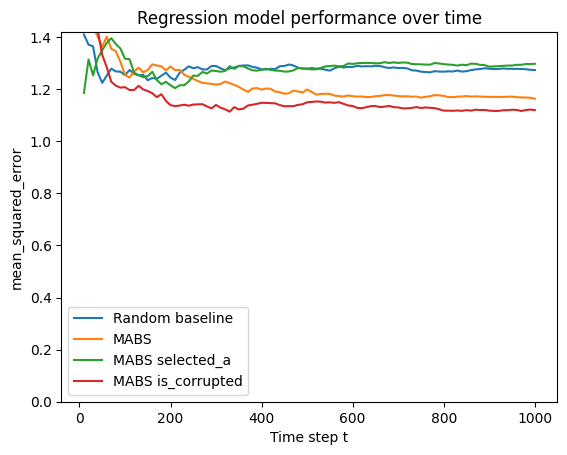

In [69]:
features_ghana  = {'selected_a':None}
x               = 'rh98'
y               = 'agbd'

crafty_boi = crafty_bandit(df_ghana, x=x\
                , y=y, features=features_ghana, T=1000, batch_size=1\
                , frac_train=0.8, frac_test=0.18, frac_val=0.02, test_freq=10, p_corrupt=0.1)

crafty_boi.benchmark_MABS(5)

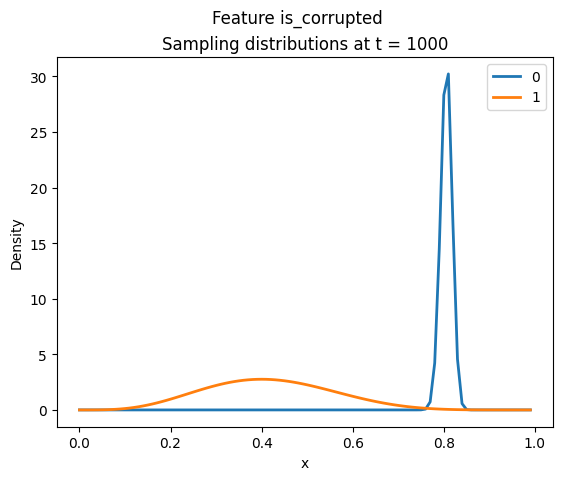

In [70]:
crafty_boi.plot_beta_dist('is_corrupted')

Summary: the agent performs as well as randomly selecting datapoints for the features tested. This is hardly surprising though. In simple linear regression, the model class considered is small.

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_boi = bandit(df_ghana, x='rh98', y='agbd', features=features, T=500, batch_size=1)
bandit_boi.benchmark_MABS(n_runs=10)

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_gal = bandit(df_ghana, x='rh98', y='agbd', features=features, T=500, batch_size=1)
bandit_gal.benchmark_MABS(n_runs=3)

In [ ]:
test_list = [x for x in range(51)]
test_list[10::10]

In [ ]:
features = {'beam':None, 'selected_a':None}
bandit_kid = bandit(df_ghana, x="rh98", y="agbd", features=features, T=50, batch_size=1)
bandit_kid.benchmark_MABS(n_runs=1)

Load previous bandit

In [ ]:
with open('bandit_boi.pkl', 'rb') as file:
    bandit_boi = pkl.load(file)

### Test the agent on `Appliances Energy Prediction`

We will test the agent on another dataset, `Appliances Energy Production`. The dataset consists of 19,000 measurements of household energy consumption, temperature and humidity conditions, co-located with meteorological variables. Our objective is to predict energy usage given the environmental variables.


In [ ]:
def get_df_energy():
    """
    Quick function to load & preprocess the appliances energy data.
    """
    # fetch dataset 
    appliances_energy_prediction = fetch_ucirepo(id=374)
    df_energy = appliances_energy_prediction.data['original']

    df_energy['date']       = pd.to_datetime(df_energy['date'], format='%Y-%m-%d%H:%M:%S')
    df_energy['month']      = df_energy['date'].dt.month
    # df_energy['month']      = df_energy['month'].astype('category')
    df_energy['lights']     = df_energy['lights'].astype('category')

    # difference between outside and inside temperature is a relevant variable

    df_energy['T_inside']   = df_energy.apply(lambda row: np.mean([row['T1'], row['T2'], row['T3'], row['T4'],\
                                                                   row['T5'], row['T7'], row['T8'], row['T9']])\
                                                                   , axis=1)

    df_energy['heating']    = df_energy['T_inside'] - df_energy['T6']

    df_energy['humid_in']   = df_energy.apply(lambda row: np.mean([row['RH_1'], row['RH_2'], row['RH_3'], row['RH_4'],\
                                                                   row['RH_5'], row['RH_7'], row['RH_8'], row['RH_9']])\
                                                                   , axis=1)

    df_energy['humid_diff'] = df_energy['humid_in'] - df_energy['RH_6']

    return df_energy

In [ ]:
df_energy = get_df_energy()
df_energy.columns

Column `Appliances` is the response variable (energy use in Wh). `TX` and `RHX` are temperature and relative humidity metrics for room `X`, respectively, while `lights` is the energy use of light fixtures in the house (Wh). The rest of the variables are meteorological measurements from a nearby weather station. A priori, I would expect that the `lights` variable is relevant for determining clusters, while `T_out` is a relevant predictor. 

In [ ]:
features_energy = {'month':None}

bandit_energy   = bandit(df_energy, x=['heating', 'lights', 'Press_mm_hg', 'humid_diff', 'Windspeed', 'Visibility', 'Tdewpoint']\
                        , y='Appliances', features=features_energy, T=1000, frac_train=0.8, frac_val=0.02, frac_test=0.18)

We model the appliances energy consumption using temperatures from most rooms and the relative humidity in the bathroom.

In [ ]:
bandit_energy.benchmark_MABS(n_runs=10)

Perhaps picking observations based on the month in which they are made is not a useful strategy...

In [ ]:
features_energy = {'lights':None}

bandit_energy   = bandit(df_energy, x=['heating', 'humid_diff']\
                        , y='Appliances', features=features_energy, T=1000, frac_train=0.8, frac_val=0.02, frac_test=0.18)

In [ ]:
bandit_energy.benchmark_MABS(n_runs=10)

What is R2 with model for heating and lights, no selection?

In [ ]:
appliances_energy_prediction = fetch_ucirepo(id=374)
df_orig = appliances_energy_prediction.data['original']

In [ ]:
linear_model = LinearRegression()

In [ ]:
linear_model.fit(df_orig[[col for col in df_orig.columns if col not in ['date', 'Appliances']]], df_orig['Appliances'])

In [ ]:
y_pred = linear_model.predict(df_orig[[col for col in df_orig.columns if col not in ['date', 'Appliances']]])
r2      = r2_score(df_orig['Appliances'], y_pred)
var_exp = explained_variance_score(df_orig['Appliances'], y_pred)
r2, var_exp

With all predictors and whole dataset, $R^2 = 0.16$, suggesting that this prediction task may be too difficult for separating good and bad models :/